# Usage instructions for the IceNumerics simulation package

The IceNumerics simulation package is a collection of routines that facilitate the programming of brownian dynamics simulations of colloidal ice.

The internal structure of the package is that of a wrapper for a modified version of LAMMPS. The package is able to create a colloidal ice lattice, display it, run a simulation of it's dynamics (through LAMMPS), read the results from a .lmpstrj file and count vertices. 

Unfortunatelly, the official python wrappers are very difficult to install in windows for a modified LAMMPS. Therefore this packages rely on text files for communication. The interface programs will create a LAMMPS script and an input file, so that python can use the command prompt to run these scripts. LAMMPS stores the result of the simulation in a .lmpstrj dump file, and there is a package to read this file and turn it into a ColloidalIce object.

It goes without saying that this is a very early development program and should not be expected to do many more things than what are shown here. 

## Importing the package
There are three main objects that should be imported. 
* The Spins object which is necessary to define geometry
* The ColloidalIce object which turns an array of Spins into colloids in double wells
* The Vertices object which gives statistics of vertices for the resulting ColloidalIce objects.

It is also useful to import matplotlib and numpy. These packages are very nicelly run in the Jupyter evironment.

In [1]:
import os
import sys 

sys.path.insert(0, '../')

import icenumerics as ice

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
ureg = ice.ureg

## The Spin Ice object

The first step towards a simulation is to construct a Spin Ice object. The Spin Ice will work as a template for the geometry of the Colloidal Ice later. 

To construct a Spin Ice object, we can write something like:

In [3]:
sp = ice.spins()
sp.create_lattice("square",[10,10],lattice_constant=30*ureg.um)

Next we can call the display function to see the graphic representation of the Spin Ice Object. The argument to the function is the axis object in which the figure will be plotted

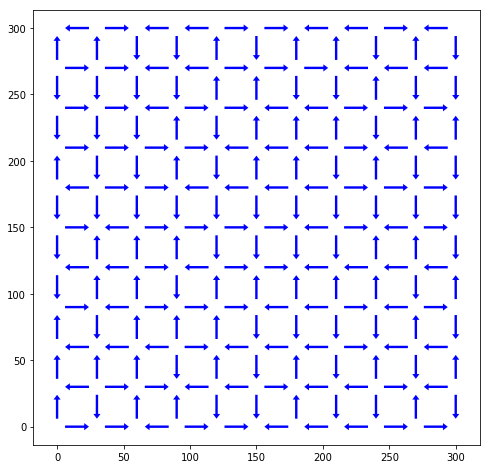

In [4]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
sp.display(ax2)

## The Colloidal Ice object

From the Spin Ice object, we can construct a Colloidal Ice object. This places a colloid in the tip of every arrow, and adds some attributess to the system such as trap separation or hill height. 

In [5]:
import numpy as np

In [6]:
particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(30*ureg.um)

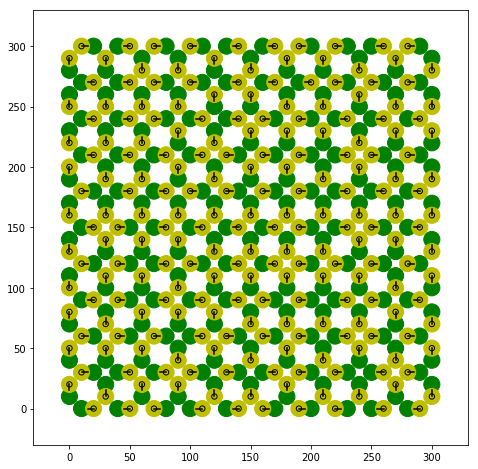

In [7]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)

## Creating Parameters and Running a Simulation

In [8]:
world = ice.world(field = 10*ureg.mT, temperature = 300*ureg.K)

In [9]:
col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = "/Users/aortiza/Desktop",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 60*ureg.s,
             output = ["x","y","z","mu"])

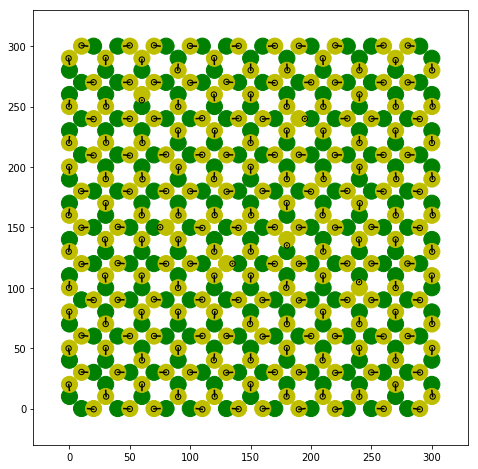

In [10]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)

In [13]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

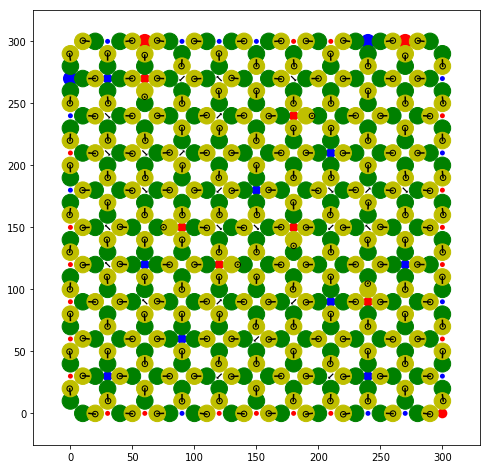

In [15]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax = ax1)
col.display(ax1)

## Reading a File and Extracting a new Colloidal Ice object

The simulation run generates input, data and output files. The output files are stored in the *lammpstrj* attribute
This attribute can be used to define a LazyOpen object, that stores a reference to the file and can be used to read specific frames.

In [7]:
DataFile = LMP.LazyOpenLAMMPSTrj(L.lammpstrj)

FrameData = DataFile.readframe(900.0);

Once we read a frame, it contains the positions of the colloids at that moment. This can be converted to a new Colloidal Ice object using the method "FrameDataToColloids". 

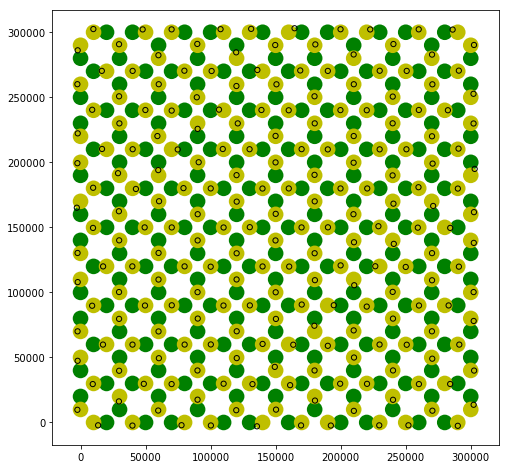

In [8]:
run = 5
C2 = C.FrameDataToColloids(FrameData,run);

f, (ax2) = plt.subplots(1,1,figsize = (8,8))

C2.display(DspObj = ax2)

## Obtaining Vertex Information

Another thing we can do is obtain, from a Colloidal Ice object, a vertex representation. 

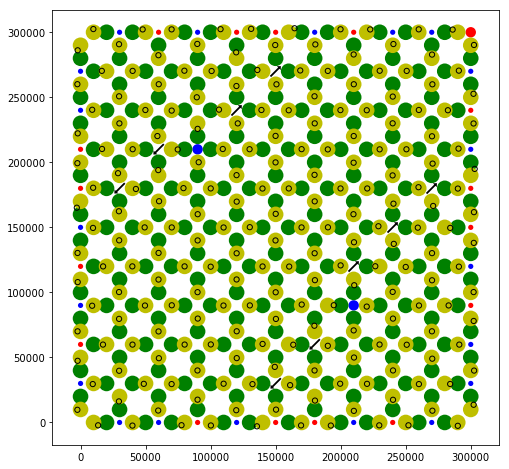

In [9]:
V = Vt.Vertices()
V = V.ColloidsToVertices(C2)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))

V.display(DspObj = ax1)
C2.display(DspObj = ax1)

As seen here, this vertex object contains information on the charge, coordination and dipole moment of a given vertex.

## Honeycomb Spin Ice

We will try the exact same procedure with a Honeycomb configuration to ensure everything works

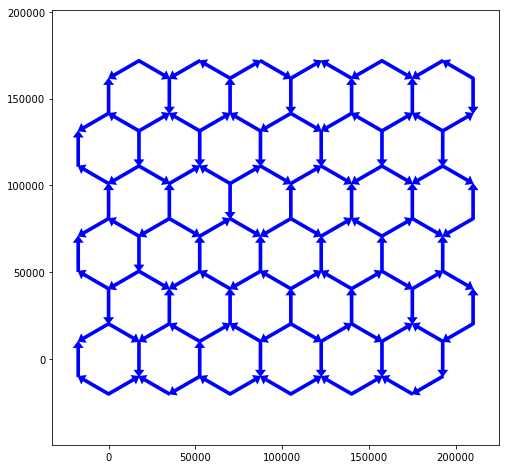

In [10]:
S = Sp.HoneycombSpinIce(6,6,Ratio = 1,Lattice = 35e3, Periodic = False, Ordering = "Random")
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
S.display(ax2)

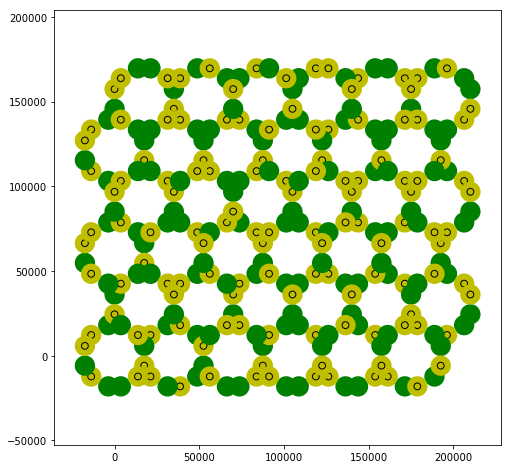

In [11]:
C = Cp.ColloidalIce(S,FieldZ=[30,1],Stiffness_Spread = 0,TrapSepRatio = 0.333333)

f, (ax2) = plt.subplots(1,1,figsize = (8,8))
C.display(ax2)

In [12]:
Params = Sp.SimulationParameters(
    Runs=5,
    Thermo=1e2,
    Timestep= 1e-2,
    Framerate = 1,Time = 60,
    TargetDir = 'DocData/Honeycomb')
L = LMP.LAMMPSScript(C,Params,test=True)
L = L.LAMMPSRun()

In [13]:
DataFile = LMP.LazyOpenLAMMPSTrj(L.lammpstrj)

FrameData = DataFile.readframe(900.0);

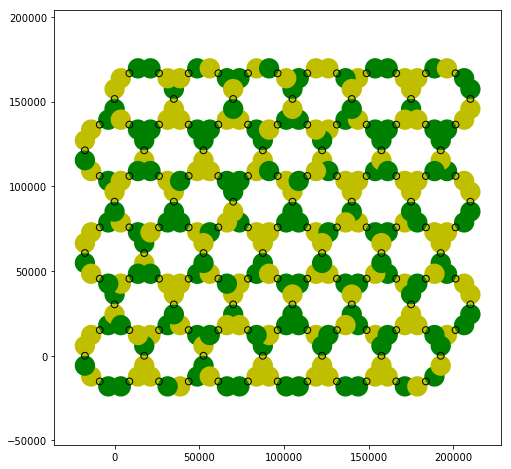

In [14]:
run = 5
C2 = C.FrameDataToColloids(FrameData,run);

f, (ax2) = plt.subplots(1,1,figsize = (8,8))

C2.display(DspObj = ax2)

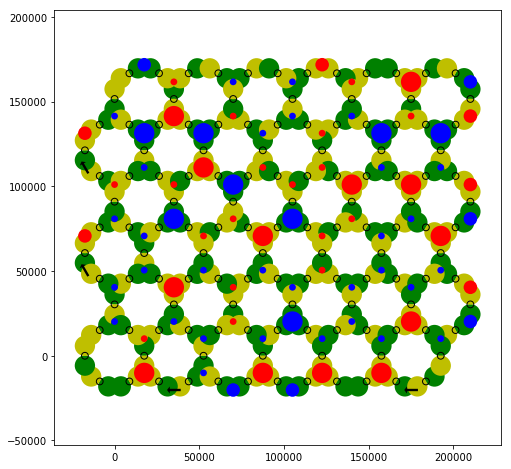

In [15]:
V = Vt.Vertices()
V = V.ColloidsToVertices(C)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))

C2.display(DspObj = ax1)
V.display(DspObj = ax1,DspCoord=False)